# ATP Tennis Data - Feature Engineering

In previous notebook, we pre-processed the ATP match data by:
* dropping columns with little data
* cleaning string columns
* imputing any data that we can reasonably impute

For this notebook, we will use the data saved from pre-processing and start doing some basic feature engineering so we can feed  our data to our models to see how we do. My goal is to start training models and see how they do as soon as possible, so we will stick with the following basic feature engineering techniques:
* encode any categorical data - ie, tournament surface, round, winner_ioc, loser_ioc
    * numeric encoding (these are categories that have some type of ordinality or importance)
        * tournament level
        * round of match
    * one hot encoding (non-oridnal categories)
        * tournament id
        * player hand
        * tournament surface
        * player id
        * player origin
* extra month from the tournament date
* label each row with 0 as Player 1 losing to Player 2 and 1 as Player 1 beats Player 2
* remove any remaining columns that we

Output of basic feature engineering:
* tournament
    * tournament id - extract from current tourney_id field
    * tournament level - encode
    * month of tournament - extract from tourney_date
    * year of tournament - extract from tourney_date
    * surface - one hot encode
    * draw size
    * best of
* player 1 and player 2
    * player id
    * rank
    * height
    * ioc - encode
    * age
    * seed
    * hand - encode
* match
    * round - encode
* label
    * whether player 1 beat player 2 - 0 - False, 1 - True
    
NOTE: For every entry in our pre-processing file, we will create 2 entries in the feature file. (1) winner is player 1 (2) winner is player 2. We do this because we want to make sure that there is no bias introduced when placing winner in either the player 1 or player 2 slots
    

## Future:
In a future notebook, I plan on implementing more advanced feature engineering with:
* look up matchup history for players
    * match-up stats for pervious matchups
* add match player record leading up to the match for each player (ie, last X matches)
* look up player stats leading up to match for each player (ie, last X matches)
* contruct 2 entries of data per row since match-up and player record leading up to a match will differe depending on which player is player 1 or 2


## Missing Data:

There are some features that are  missing from our dataset. In the future, we could look into somehow scrapping or manually getting these. I looked at the ATP website to see how to get this data, but it is not readily apparent since each player/tournament has some type of unique identifier on their website that I haven't figure out how to get. Here are some potential features to get i the future:


* tournament
    * tournament location - ie, city, country
    * whether tournament is indoor or outdoors
    * prize money
* player
    * weight
    * player experience - ie, number of years as a pro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.model_util import RSTATE
random.seed(RSTATE)


%matplotlib inline
sns.set()

In [2]:
# Contants
START_YEAR = 1985
END_YEAR = 2019

DATASET_DIR = '../datasets'
MODEL_DIR = '../models'

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    PREPROCESSED_FILE = f'{DATASET_DIR}/test-preprocessed.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-raw_diff-ohe.csv'
else:
    # this is the file we generated from our pre-processing notebook
    PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-raw_diff-ohe.csv'



In [3]:
pre = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])

In [4]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

## Let's look at the data to make sure all the types are correct before we being

In [5]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

In [6]:
pre.sample(5).T

,68192,78873,44958,75243,16284
tourney_id,2007-404,2011-5012,1999-409,2009-560,1990-430
tourney_name,indian wells masters,johannesburg,atlanta,us open,wembley
surface,hard,hard,clay,hard,carpet
draw_size,128,32,32,128,32
tourney_level,m,a,a,g,a
tourney_date,2007-03-05 00:00:00,2011-01-31 00:00:00,1999-04-26 00:00:00,2009-08-31 00:00:00,1990-11-05 00:00:00
match_num,14,20,20,1,22
winner_id,104559,103971,103206,103819,101723
winner_seed,70,12,5,1,19
winner_name,teymuraz gabashvili,karol beck,sebastien grosjean,roger federer,magnus larsson


# Tournament Info

* tournament id - extract from current tourney_id field
* tournament level - one hot encode
* month of tournament - extract from tourney_date
* year of tournament - extract from tourney_date
* surface - one hot encode
* draw size
* best of


### Extract tournment ID aand Encode

Since players may have an affinity for certainly tournaments because of location or conditions, we should include this into our features

First let's rename the columns since it's rather confusing - currently, tourney_id is a composite of {year}-{id}. ID is alphanumeric so we need to encode these

In [7]:
matches = pre
matches = matches.rename({"tourney_id": "tourney_year_plus_id"}, axis=1)
matches["tourney_id"] = matches.tourney_year_plus_id.apply(lambda x: x.split("-")[1])
matches.sample(5, random_state=RSTATE).tourney_id

57294    311
20858    434
17975    440
21211    520
89342    301
Name: tourney_id, dtype: object

In [8]:


tidle = LabelEncoder()
tid_labels = tidle.fit_transform(matches['tourney_id'])
tid_map = {label: num for num, label in enumerate(tidle.classes_)}
print(tid_map)

matches["tourney_id_label"] = matches["tourney_id"].map(tid_map)

# save off map to be used later
with open(f'{MODEL_DIR}/tid_map.json', 'w') as file:
    json.dump(tid_map, file)
    
matches.sample(5)[["tourney_id", "tourney_id_label"]]

{'0301': 0, '0308': 1, '0311': 2, '0314': 3, '0315': 4, '0316': 5, '0319': 6, '0321': 7, '0322': 8, '0328': 9, '0329': 10, '0337': 11, '0341': 12, '0352': 13, '0360': 14, '0375': 15, '0402': 16, '0407': 17, '0410': 18, '0414': 19, '0421': 20, '0424': 21, '0425': 22, '0429': 23, '0439': 24, '0451': 25, '0495': 26, '0496': 27, '0499': 28, '0500': 29, '0506': 30, '0533': 31, '0568': 32, '0605': 33, '0717': 34, '0741': 35, '0773': 36, '0891': 37, '1536': 38, '1720': 39, '201': 40, '215': 41, '224': 42, '2276': 43, '237': 44, '240': 45, '301': 46, '302': 47, '303': 48, '304': 49, '305': 50, '306': 51, '308': 52, '309': 53, '310': 54, '311': 55, '312': 56, '313': 57, '314': 58, '315': 59, '316': 60, '317': 61, '318': 62, '319': 63, '321': 64, '322': 65, '323': 66, '325': 67, '326': 68, '327': 69, '328': 70, '329': 71, '330': 72, '332': 73, '3348': 74, '336': 75, '337': 76, '338': 77, '339': 78, '341': 79, '3465': 80, '348': 81, '352': 82, '354': 83, '357': 84, '359': 85, '360': 86, '366': 87

,tourney_id,tourney_id_label
94410,0328,9
67310,337,76
92525,m006,199
3454,403,93
16502,580,158


### Tournament Level

Tournament level does have some type of implicit ordinality to them since tournaments are worth different points according to their levels with 'g' (grand slams) worth the most number of points

We will do a custom encoding for these

Here are the point values for winner the levels:
* g - grand slam - 2000
* f - tour final - 1500
* m - masters - 1000
* a - other tour event - anywhere between 250 to 500 depending on the series

In [9]:
np.unique(matches.tourney_level)

array(['a', 'f', 'g', 'm'], dtype=object)

In [10]:
import json

level_map = {'g': 1, 'f': 2, 'm': 3, 'a': 4}
matches["tourney_level_label"] = matches['tourney_level'].map(level_map)
# let's check our work
matches.sample(5)[["tourney_level", "tourney_level_label"]]

# let's save off the map for later use
with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
    json.dump(level_map, file)

### Tournamant year and Month

We can extract this from the tourney_date

In [11]:
matches["tourney_year"] = matches.tourney_date.dt.year
matches["tourney_month"] = matches.tourney_date.dt.month
matches.sample(5)[["tourney_year", "tourney_month", "tourney_date"]]

,tourney_year,tourney_month,tourney_date
62831,2005,5,2005-05-02
88762,2014,8,2014-08-25
3741,1987,4,1987-04-06
68267,2007,3,2007-03-05
36424,1996,8,1996-08-12


### Tournament Surface

There is no ordinality here so we can just use a label encoder

In [12]:

surface_le = LabelEncoder()
surface_labels = surface_le.fit_transform(matches['surface'])
surface_map = {label: num for num, label in enumerate(surface_le.classes_)}
print(surface_map)

matches["surface_label"] = matches["surface"].map(surface_map)

# save off map to be used later
with open(f'{MODEL_DIR}/surface_map.json', 'w') as file:
    json.dump(surface_map, file)
    
matches.sample(5)[["surface", "surface_label"]]

{'carpet': 0, 'clay': 1, 'grass': 2, 'hard': 3}


,surface,surface_label
41313,hard,3
40431,carpet,0
11731,clay,1
19132,clay,1
46397,clay,1


# Generate Player Features

Most are already numbers that we can feed into the model - we will just keep these for now

### Player origin (ioc)

Again there is no ordinality to this so we will use the LabelEncoder

In [13]:
ioc_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
ioc_labels = ioc_le.fit_transform(matches["loser_ioc"].append(matches["winner_ioc"]))
ioc_map = {label: num for num, label in enumerate(ioc_le.classes_)}
print(ioc_map)

matches["loser_ioc_label"] = matches["loser_ioc"].map(ioc_map)
matches["winner_ioc_label"] = matches["winner_ioc"].map(ioc_map)

# save off map to be used later
with open(f'{MODEL_DIR}/ioc_map.json', 'w') as file:
    json.dump(ioc_map, file)
    
matches.sample(5)[["loser_ioc", "loser_ioc_label", "winner_ioc", "winner_ioc_label"]]

{'alg': 0, 'arg': 1, 'arm': 2, 'aus': 3, 'aut': 4, 'aze': 5, 'bah': 6, 'bar': 7, 'bel': 8, 'ben': 9, 'ber': 10, 'bih': 11, 'blr': 12, 'bol': 13, 'bra': 14, 'bul': 15, 'can': 16, 'chi': 17, 'chn': 18, 'civ': 19, 'col': 20, 'crc': 21, 'cro': 22, 'cub': 23, 'cyp': 24, 'cze': 25, 'den': 26, 'dom': 27, 'ecu': 28, 'egy': 29, 'esa': 30, 'esp': 31, 'est': 32, 'fin': 33, 'fra': 34, 'gbr': 35, 'geo': 36, 'ger': 37, 'gre': 38, 'hai': 39, 'hkg': 40, 'hun': 41, 'ina': 42, 'ind': 43, 'iri': 44, 'irl': 45, 'isr': 46, 'ita': 47, 'jam': 48, 'jpn': 49, 'kaz': 50, 'ken': 51, 'kor': 52, 'kuw': 53, 'lat': 54, 'ltu': 55, 'lux': 56, 'mar': 57, 'mas': 58, 'mda': 59, 'mex': 60, 'mkd': 61, 'mon': 62, 'ned': 63, 'ngr': 64, 'nor': 65, 'nzl': 66, 'pak': 67, 'par': 68, 'per': 69, 'phi': 70, 'pol': 71, 'por': 72, 'pur': 73, 'qat': 74, 'rou': 75, 'rsa': 76, 'rus': 77, 'sen': 78, 'slo': 79, 'srb': 80, 'sui': 81, 'svk': 82, 'swe': 83, 'tha': 84, 'tog': 85, 'tpe': 86, 'tun': 87, 'tur': 88, 'uae': 89, 'ukr': 90, 'unk': 9

,loser_ioc,loser_ioc_label,winner_ioc,winner_ioc_label
16698,rus,77,fra,34
82274,cyp,24,ita,47
82904,svk,82,fra,34
69293,per,69,ned,63
18554,rou,75,fra,34


### Player Hand - (l/r/u)

This is simple categorial data - will use LabelEncoder

In [14]:
hand_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
hand_labels = hand_le.fit_transform(matches["loser_hand"].append(matches["winner_hand"]))
hand_map = {label: num for num, label in enumerate(hand_le.classes_)}
print(hand_map)

matches["loser_hand_label"] = matches["loser_hand"].map(hand_map)
matches["winner_hand_label"] = matches["winner_hand"].map(hand_map)

# save off map to be used later
with open(f'{MODEL_DIR}/hand_map.json', 'w') as file:
    json.dump(hand_map, file)
    
matches.sample(9)[["loser_hand", "loser_hand_label", "winner_hand", "winner_hand_label"]]

{'l': 0, 'r': 1, 'u': 2}


,loser_hand,loser_hand_label,winner_hand,winner_hand_label
49585,l,0,l,0
22884,r,1,r,1
88101,r,1,r,1
75414,r,1,r,1
66241,r,1,r,1
65137,r,1,l,0
93785,l,0,r,1
66095,l,0,r,1
29357,r,1,r,1


## Match Features

Only feature we will use for now is round. There is an ordinality to the rounds so we will use a custome encoding

Couple issues with this:

'rr' - means round robin. This usually means that all players in a tournament is divided into multiple flights (ie, 2). All players in the flight play against each other. The year end final for instance has 8 players. Top 2 players from each flight make it to semi finals. Winner of that match goes to finals. So rr could mean any of the 3 matches a player would play in the flight. We will just pick the next unique number to encode this.

https://en.wikipedia.org/wiki/ATP_Finals

'br' - Not sure what this indicates. Will encode this as the last value

<red>try one hot encoding and see the effect</red>

In [15]:
np.unique(matches["round"])

array(['br', 'f', 'qf', 'r128', 'r16', 'r32', 'r64', 'rr', 'sf'],
      dtype=object)

In [16]:
round_map = {'f': 1, 
            'sf': 2,
            'qf': 3,
            'r16': 4,
            'r32': 5,
            'r64': 6,
            'r128': 7,
            'rr': 8,
            'br': 9}
matches["round_label"] = matches["round"].map(round_map)

# save off map to be used later
with open(f'{MODEL_DIR}/round_map.json', 'w') as file:
    json.dump(round_map, file)
    
matches.sample(5)[["round", "round_label"]]


,round,round_label
51713,r32,5
72528,r32,5
49878,r16,4
21036,r32,5
8557,r64,6


# Let's check out our data one more time

In [17]:
matches.sample(5).T

,78285,9146,64565,91036,54706
tourney_year_plus_id,2010-5014,1988-326,2005-352,2015-414,2002-315
tourney_name,shanghai masters,brisbane,paris masters,hamburg,newport
surface,hard,hard,carpet,clay,grass
draw_size,64,32,64,32,32
tourney_level,m,a,m,a,a
tourney_date,2010-10-10 00:00:00,1988-10-04 00:00:00,2005-10-31 00:00:00,2015-07-27 00:00:00,2002-07-08 00:00:00
match_num,24,14,28,16,27
winner_id,103344,100618,103786,103990,103758
winner_seed,17,20,3,2,5
winner_name,ivan ljubicic,leif shiras,nikolay davydenko,tommy robredo,taylor dent


# 1 - Generate Features and Ground Truth

This is going to be a little bit tricky. If we leave the columns as it, all of our labels for winner/loser would be 1 since winner column is first.

Instead, we are going to have to loop through all rows and randomly place winner or loser as player 1 so that we can have labels that are both 0 and 1

In [18]:

tourney_cols = ["tourney_id", "tourney_id_label", "tourney_level", "tourney_level_label", "tourney_year", "tourney_month", "surface", "surface_label", "draw_size", "round", "round_label", "best_of"]

def generate_feature_row(idx: int, row: pd.Series) -> dict:
    if idx % 10000 == 0:
        print(f'Processing index {idx}')
    
    m1 = {}
    m2 = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m1[tc] = row[tc]
        m2[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1_player = {
        "p1": row.winner_id,
        "p1_rank": row.winner_rank,
        "p1_ht": row.winner_ht,
        "p1_ioc": row.winner_ioc,
        "p1_ioc_label": row.winner_ioc_label,
        "p1_age": row.winner_age,
        "p1_seed": row.winner_seed,
        "p1_hand": row.winner_hand,
        "p1_hand_label": row.winner_hand_label,
        "p2": row.loser_id,
        "p2_rank": row.loser_rank,
        "p2_ht": row.loser_ht,
        "p2_ioc": row.loser_ioc,
        "p2_ioc_label": row.loser_ioc_label,
        "p2_age": row.loser_age,
        "p2_seed": row.loser_seed,
        "p2_hand": row.loser_hand,
        "p2_hand_label": row.loser_hand_label,
        "p1_winner": 1,
        "rank_diff": row.winner_rank - row.loser_rank,
        "ht_diff": row.winner_ht - row.loser_ht,
        "age_diff": row.winner_age - row.loser_age,
        "seed_diff": row.winner_seed - row.loser_seed,

    }
    m2_player = {
        "p1": row.loser_id,
        "p1_rank": row.loser_rank,
        "p1_ht": row.loser_ht,
        "p1_ioc": row.loser_ioc,
        "p1_ioc_label": row.loser_ioc_label,
        "p1_age": row.loser_age,
        "p1_seed": row.loser_seed,
        "p1_hand": row.loser_hand,
        "p1_hand_label": row.loser_hand_label,
        "p2": row.winner_id,
        "p2_rank": row.winner_rank,
        "p2_ht": row.winner_ht,
        "p2_ioc": row.winner_ioc,
        "p2_ioc_label": row.winner_ioc_label,
        "p2_age": row.winner_age,
        "p2_seed": row.winner_seed,
        "p2_hand": row.winner_hand,
        "p2_hand_label": row.winner_hand_label,
        "p1_winner": 0,
        "rank_diff": row.loser_rank - row.winner_rank,
        "ht_diff": row.loser_ht - row.winner_ht,
        "age_diff": row.loser_age - row.winner_age,
        "seed_diff": row.loser_seed - row.winner_seed,
    }
    m1.update(m1_player)
    m2.update(m2_player)

    return m1, m2

features = pd.DataFrame()
for idx, row in matches.iterrows():
    d1, d2 = generate_feature_row(idx, row)
    features = features.append(d1, ignore_index=True)
    features = features.append(d2, ignore_index=True)

features.info()

Processing index 0
Processing index 10000
Processing index 20000
Processing index 30000
Processing index 40000
Processing index 50000
Processing index 60000
Processing index 70000
Processing index 80000
Processing index 90000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199910 entries, 0 to 199909
Data columns (total 35 columns):
age_diff               199910 non-null float64
best_of                199910 non-null float64
draw_size              199910 non-null float64
ht_diff                199910 non-null float64
p1                     199910 non-null float64
p1_age                 199910 non-null float64
p1_hand                199910 non-null object
p1_hand_label          199910 non-null float64
p1_ht                  199910 non-null float64
p1_ioc                 199910 non-null object
p1_ioc_label           199910 non-null float64
p1_rank                199910 non-null float64
p1_seed                199910 non-null float64
p1_winner              199910 non-null float64
p2     

In [19]:
type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "p1": np.int32,
    "p1_rank": np.int32,
    "p1_ioc_label": np.int32,
    "p1_seed": np.int32,
    "p1_hand_label": np.int32,
    "p2": np.int32,
    "p2_rank": np.int32,
    "p2_ioc_label": np.int32,
    "p2_seed": np.int32,
    "p2_hand_label": np.int32,
    "p1_winner": np.int32,
    "rank_diff": np.int32,
    "ht_diff": np.int32,
    "age_diff": np.int32,
    "seed_diff": np.int32,
    "best_of": np.int32,
}

features = features.astype(type_map)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199910 entries, 0 to 199909
Data columns (total 35 columns):
age_diff               199910 non-null int32
best_of                199910 non-null int32
draw_size              199910 non-null int32
ht_diff                199910 non-null int32
p1                     199910 non-null int32
p1_age                 199910 non-null float64
p1_hand                199910 non-null object
p1_hand_label          199910 non-null int32
p1_ht                  199910 non-null float64
p1_ioc                 199910 non-null object
p1_ioc_label           199910 non-null int32
p1_rank                199910 non-null int32
p1_seed                199910 non-null int32
p1_winner              199910 non-null int32
p2                     199910 non-null int32
p2_age                 199910 non-null float64
p2_hand                199910 non-null object
p2_hand_label          199910 non-null int32
p2_ht                  199910 non-null float64
p2_ioc                 

In [20]:
features.sample(5).T

,199401,189001,89568,23240,102905
age_diff,9,-6,0,0,1
best_of,3,3,3,3,3
draw_size,32,64,64,64,32
ht_diff,-15,-5,5,5,5
p1,105138,106298,102610,100901,101888
p1_age,30.52,22.69,23.8,26.35,30.2
p1_hand,r,r,r,r,r
p1_hand_label,1,1,1,1,1
p1_ht,183,185,180,185,190
p1_ioc,esp,fra,esp,usa,cze


### Since we had a bug inially let's check to make sure seed diff is never greater than rank diff

In [21]:
# verify that seed diff is <= rank diff
features[abs(features.seed_diff) > abs(features.rank_diff)][["seed_diff", "rank_diff"]]

,seed_diff,rank_diff
548,6,5
549,-6,-5
1530,5,-3
1531,-5,3
1548,-2,-1
...,...,...
198945,-3,-1
199536,-7,-5
199537,7,5
199542,-4,-3


### We should have the same winners and losers

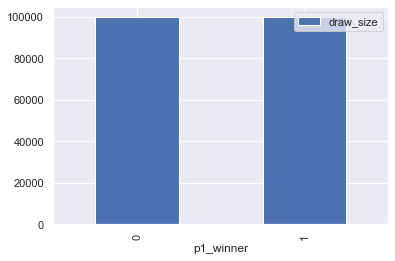

In [22]:
features[['p1_winner','draw_size']].groupby("p1_winner").count().plot(kind='bar')

# 2 - Generate Features and Ground Truth Using One Hot Encoding

For our categorical data, we are currently using label encoding. Label encoding basically assigned a unique number to each categorical value and we use this as features

Alternative method is to use one hot encoding. Each category will be coverted into a unique column - 1 will be assigned to the column if the value matches that column, all other columns will have 0 value. We will try this method to see if it makes a difference in our models

Our categories are:
* player id
* player hand
* player ioc (origin)
* tournament ID
* surface
* best_of

In [35]:
from sklearn.preprocessing import OneHotEncoder
import pickle

# def encode_columns(df: pd.DataFrame, col1: str, col2: str = None, col_labels: list = None) -> (pd.DataFrame, OneHotEncoder):
def ohe_columns(name: str, df: pd.DataFrame, col1: str, col2: str = None, drop_column = False) -> (pd.DataFrame, OneHotEncoder):
    """
    Encodes columns and returns a DataFrame and encoder
    :param: name - encoder name to save
    :param: df - dataframe with data
    :param: col1 - name of first column to encode (ie, p1 column)
    :param: col2 - name of 2nd column to encode (ie, p2 column) - we need to do this so that the encoder knows about all values for p1 and p2
    :param: drop_column - indicates whether we should be dropping the original column from dataset - ie,  if original column is text based
    
    :return: dataframe with encoded values and column names
    :return: encoder
    """
    encoded_return = None
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype=np.int)
    if col2:
        # sometimes not all values are in one column between p1 and p2, we have to melt them to fit the encoder
        ohe.fit(pd.melt(df[[col1, col2]])[["value"]])
        encoded_array1 = ohe.transform(df[[col1]])
        encoded_array2 = ohe.transform(df[[col2]])
        encoded_df = pd.DataFrame(encoded_array1, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_df2 = pd.DataFrame(encoded_array2, columns=[col2 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_pd = pd.concat([encoded_df, encoded_df2], axis=1)
    else:
        encoded_array = ohe.fit_transform(df[[col1]])
        encoded_pd = pd.DataFrame(encoded_array, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])

    # save off our encoder
    pickle.dump(ohe, open(f'{MODEL_DIR}/{name}_ohe.pkl', 'wb'))
    
    # drop old columns
    return_pd = pd.concat([df, encoded_pd], axis=1)
    if drop_column:
        if col2:
            return_pd = return_pd.drop([col1, col2], axis=1)
        else:
            return_pd = return_pd.drop([col1], axis=1)
    
    
    return return_pd, ohe



# Save Dataset

This is a comprehensive dataset that has all columns so we can filter later to experiement

In [25]:
import re
[col for col in features.columns if not re.search(r'(p1|p2)_ioc_', col) and not re.search(r'(p1|p2)_[\d]+', col)]

['age_diff',
 'best_of',
 'draw_size',
 'ht_diff',
 'p1',
 'p1_age',
 'p1_hand',
 'p1_hand_label',
 'p1_ht',
 'p1_ioc',
 'p1_rank',
 'p1_seed',
 'p1_winner',
 'p2',
 'p2_age',
 'p2_hand',
 'p2_hand_label',
 'p2_ht',
 'p2_ioc',
 'p2_rank',
 'p2_seed',
 'rank_diff',
 'round',
 'round_label',
 'seed_diff',
 'surface',
 'surface_label',
 'tourney_id',
 'tourney_id_label',
 'tourney_level',
 'tourney_level_label',
 'tourney_month',
 'tourney_year']

In [37]:
# get rid of string value columns - ie, round, tourney_level
# the following string value columns will be OHE later: *_hand, surface, *_ioc, tourney_id, p1/p2
raw_diff_ohe_columns = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand", "p1_ht", "p1_ioc", "p1_rank", "p1_seed", "p1_hand_label",
                   "p2", "p2_age", "p2_hand", "p2_ht", "p2_ioc", "p2_rank", "p2_seed", "p2_hand_label",
                  "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]



features_raw_diff_ohe = features[raw_diff_ohe_columns].copy()
print(features_raw_diff_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())


  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       r    usa    nzl    hard  100617  108265        301        3
1       r       r    nzl    usa    hard  108265  100617        301        3
2       r       l    nzl    aus    hard  100587  100680        301        3
3       l       r    aus    nzl    hard  100680  100587        301        3
4       r       r    aus    arg    hard  100868  100751        301        3


In [38]:
features_raw_diff_ohe, hand_ohe = ohe_columns("hand", features_raw_diff_ohe, "p1_hand", "p2_hand", drop_column = True)
features_raw_diff_ohe, surface_ohe = ohe_columns("surface", features_raw_diff_ohe, "surface", drop_column = True)
features_raw_diff_ohe, ioc_ohe = ohe_columns("ioc", features_raw_diff_ohe, "p1_ioc", "p2_ioc", drop_column = True)
features_raw_diff_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_raw_diff_ohe, "tourney_id", drop_column = True)
features_raw_diff_ohe, player_id_ohe = ohe_columns("player_id", features_raw_diff_ohe, "p1", "p2", drop_column = False)
features_raw_diff_ohe, best_of_ohe = ohe_columns("best_of", features_raw_diff_ohe, "best_of", drop_column = False)


features_raw_diff_ohe.head()

,best_of,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,p1,p1_age,p1_ht,p1_rank,...,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734,best_of_3,best_of_5
0,3,32,5,4,1,1986,100617,26.380000,193.0,43,...,0,0,0,0,0,0,0,0,1,0
1,3,32,5,4,1,1986,108265,25.638053,198.0,269,...,0,0,0,0,0,0,0,0,1,0
2,3,32,5,4,1,1986,100587,26.810000,188.0,300,...,0,0,0,0,0,0,0,0,1,0
3,3,32,5,4,1,1986,100680,25.600000,178.0,402,...,0,0,0,0,0,0,0,0,1,0
4,3,32,5,4,1,1986,100868,23.220000,188.0,221,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# print out our non-encoded columns
import re
print([col for col in features_raw_diff_ohe.columns \
       if not re.match(r'(p1|p2)_[\d]+', col) \
       and not re.match(r"(p1|p2)_ioc_", col) \
       and not re.match("tourney_id_", col)])

['best_of', 'draw_size', 'round_label', 'tourney_level_label', 'tourney_month', 'tourney_year', 'p1', 'p1_age', 'p1_ht', 'p1_rank', 'p1_seed', 'p1_hand_label', 'p2', 'p2_age', 'p2_ht', 'p2_rank', 'p2_seed', 'p2_hand_label', 'age_diff', 'ht_diff', 'seed_diff', 'rank_diff', 'p1_winner', 'p1_hand_l', 'p1_hand_r', 'p1_hand_u', 'p2_hand_l', 'p2_hand_r', 'p2_hand_u', 'surface_carpet', 'surface_clay', 'surface_grass', 'surface_hard', 'best_of_3', 'best_of_5']


In [40]:
# order columns alphabetically so it's easier to compare later
features_raw_diff_ohe = features_raw_diff_ohe.reindex(sorted(features_raw_diff_ohe.columns), axis=1)
features_raw_diff_ohe.to_csv(FEATURE_FILE_RAW_DIFF_OHE, index=False)
features_raw_diff_ohe.shape

(199910, 5267)